<a href="https://colab.research.google.com/github/Kraken2003/GANs/blob/main/anime_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sharl008
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:06<00:00, 63.3MB/s]


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

In [3]:
images = r'/content/animefacedataset'

In [27]:
image_size = 64
batch_size = 128
norm = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm)])

ds = ImageFolder(root= images , transform = transf)

train_dl = DataLoader(ds, batch_size, shuffle=True)

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [32]:
device

device(type='cuda')

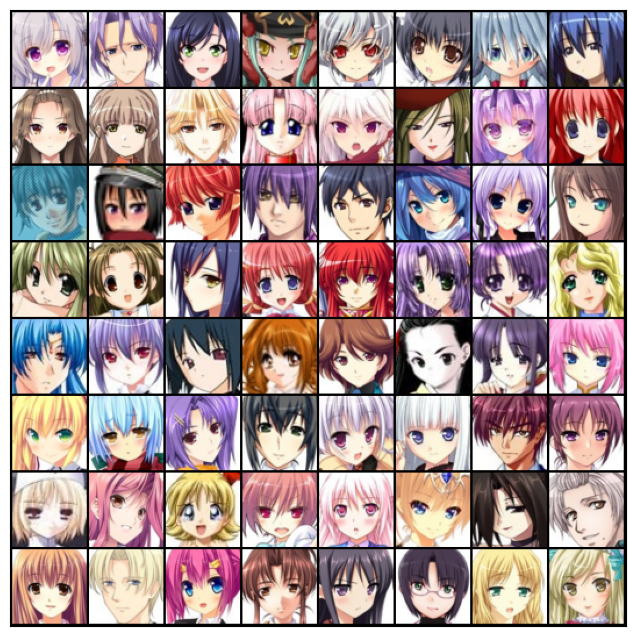

In [33]:
def denorm(img_tensors):
    return img_tensors * norm[1][0] + norm[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(train_dl)

In [34]:
import torch.nn as nn

In [35]:
discriminator = nn.Sequential(

    #3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    #64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    #128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    #256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    #512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()

    #linear output

    )

In [36]:
latent_size = 128
generator = nn.Sequential(

    #128 x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    #512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    #256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    #128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    #64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

    #3 x 64 x 64

)

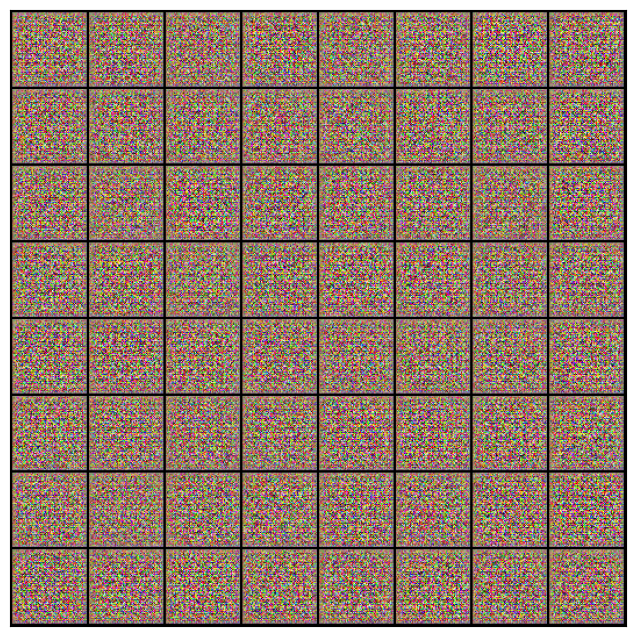

In [37]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
show_images(fake_images)

In [38]:
import torch.nn.functional as F

In [39]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    #teach it what a real image is
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    #we make a fake image
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    #test if it can distinguish a fake image from a real one
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [40]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # make fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # get feedback from the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

Saving generated-images-0000.png


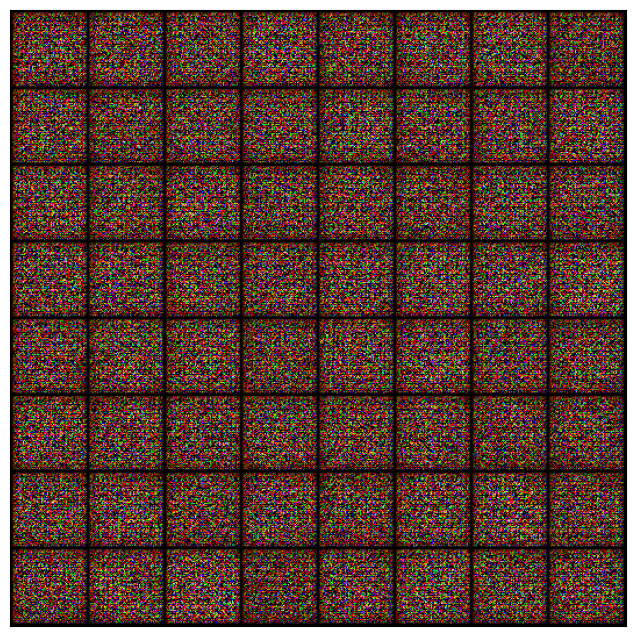

In [41]:
from torchvision.utils import save_image
os.makedirs('progress', exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join('progress', fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
fixed_latent = torch.randn(64, latent_size, 1, 1)
save_samples(0, fixed_latent)

In [42]:
import time
from tqdm.notebook import tqdm

In [47]:
def fit(epochs, lr, start_idx=1):
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        start_time = time.time()
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, , Time elapsed: {:.2f} seconds".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score, epoch_time))

        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores